# Setup

In [1]:
import os
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.utils import save_image, make_grid
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/CS5242-2025/final_report/generative_models/vae/")

Mounted at /content/drive


In [3]:
checkpoint_dir = "train_runs_vae"
os.makedirs(checkpoint_dir, exist_ok=True)

# Data Preprocessing

In [ ]:
# Custom dataset
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = [
            os.path.join(data_dir, f) for f in os.listdir(data_dir)
            if f.endswith('.jpg') or f.endswith('.png')
        ]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image


In [ ]:
# Define preprocessing
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# CHANGE IF USING COLAB (download manually)
data_dir = "/kaggle/input/flickrfaceshq-dataset-ffhq"

full_dataset = CustomImageDataset(data_dir=data_dir, transform=transform)

# Split into 80% train, 20% eval
train_size = int(0.8 * len(full_dataset))
eval_size = len(full_dataset) - train_size
train_dataset, eval_dataset = random_split(full_dataset, [train_size, eval_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
eval_loader = DataLoader(eval_dataset, batch_size=64, shuffle=False, num_workers=4)

# Model

In [4]:
class VAE(nn.Module):
    def __init__(self, input_channel=3, latent_dim=128, image_size=256):
        super(VAE, self).__init__()

        self.latent_dim = latent_dim

        hidden_channels = [32, 64, 128, 256, 512]

        # Build Encoder
        encoder_layers = []
        i_channel = input_channel
        # (3,256,256) -> (32,128,128) -> (64,64,64) -> (128,32,32) -> (256,16,16) -> (512,8,8)
        for h_channel in hidden_channels:
            encoder_layers.append(
                nn.Sequential(
                    nn.Conv2d(i_channel, h_channel, kernel_size=3, stride=2, padding=1),
                    nn.BatchNorm2d(h_channel),
                    nn.LeakyReLU())
            )
            i_channel = h_channel
        last_h_channel = hidden_channels[-1]
        self.encoder = nn.Sequential(*encoder_layers)

        # (512,8,8) -> (32768,) -> (latent,)
        hidden_size = image_size // 2**(len(hidden_channels))
        self.mean_layer = nn.Linear(last_h_channel * hidden_size**2, latent_dim)
        self.var_layer = nn.Linear(last_h_channel * hidden_size**2 , latent_dim)

        # Build Decoder
        # (latent,) -> (32768,) -> (512,8,8)
        self.decoder_input = nn.Linear(latent_dim, last_h_channel * hidden_size**2)

        hidden_channels.reverse()
        decoder_layers = []
        # (512,8,8) -> (256,16,16) -> (128,32,32) -> (64,64,64) -> (32,128,128)
        for i in range(len(hidden_channels) - 1):
            i_channel = hidden_channels[i]
            h_channel = hidden_channels[i + 1]
            decoder_layers.append(
                nn.Sequential(
                    nn.ConvTranspose2d(i_channel, h_channel, kernel_size=3, stride=2, padding=1, output_padding=1),  # Fixed here
                    nn.BatchNorm2d(h_channel),
                    nn.LeakyReLU())
            )
        first_h_channel = hidden_channels[-1]
        self.decoder = nn.Sequential(*decoder_layers)

        # (32,128,128) -> (3,256,256)
        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(first_h_channel, input_channel, kernel_size=3,
                                               stride=2, padding=1, output_padding=1),
                            nn.Tanh())

    def encode(self, input):
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)

        mean = self.mean_layer(result)
        log_var = self.var_layer(result)

        return [mean, log_var]

    def decode(self, z):
        result = self.decoder_input(z)
        result = result.view(-1, 512, 8, 8)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mean, logvar):
        logvar = torch.clamp(logvar, min=-10.0, max=10.0)
        sd = torch.exp(0.5 * logvar)
        eps = torch.randn_like(sd)
        return eps * sd + mean

    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameterize(mean, log_var)
        x_hat = self.decode(z)
        return [x_hat, x, mean, log_var]

    def loss_function(self, result, kld_weight=0.00025) -> dict:
        recon_output, ori_input, mean, log_var = result
        log_var = torch.clamp(log_var, min=-10.0, max=10.0)
        recon_loss = nn.functional.mse_loss(recon_output, ori_input)

        kl_div = torch.mean(-0.5 * torch.sum(1 + log_var - mean ** 2 - log_var.exp(), dim = 1), dim = 0)
        total_loss = recon_loss + kld_weight * kl_div

        return {
            'loss': total_loss,
            'reconstruction_loss': recon_loss.detach(),
            'kl_div': -kl_div.detach()
        }

    def sample(self, n_samples, current_device):
        z = torch.randn(n_samples, self.latent_dim)
        z = z.to(current_device)
        samples = self.decode(z)
        return samples

    def reconstruct(self, input_image):
        return self.forward(input_image)[0]


def show_images(images, nrow=4):
    images = images.clamp(0, 1)
    grid = make_grid(images.cpu(), nrow=nrow)
    plt.figure(figsize=(12, 12))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.show()


# Training

In [ ]:
def train(model, train_loader, eval_loader, epochs=40, lr=1e-4, gamma = 0.95, weight_decay=0, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = gamma)

    train_losses = []
    eval_losses = []
    best_val_loss = float('inf')

    for epoch in range(epochs):
        # Training
        model.train()
        total_train_loss = 0
        for batch in tqdm(train_loader, desc=f"[Train] Epoch {epoch+1}/{epochs}"):
            batch = batch.to(device)
            optimizer.zero_grad()

            result = model(batch)

            loss_dict = model.loss_function(result)
            loss = loss_dict['loss']

            loss.backward()
            optimizer.step()
            scheduler.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Evaluation
        model.eval()
        total_eval_loss = 0
        with torch.no_grad():
            for batch in tqdm(eval_loader, desc=f"[Eval ] Epoch {epoch+1}/{epochs}"):
                batch = batch.to(device)
                result = model(batch)
                loss_dict = model.loss_function(result)
                total_eval_loss += loss_dict['loss'].item()
        avg_eval_loss = total_eval_loss / len(eval_loader)
        eval_losses.append(avg_eval_loss)

        print(f"Epoch {epoch+1:>2}: Train Loss = {avg_train_loss:.4f}, Eval Loss = {avg_eval_loss:.4f}")

        if epoch%5 == 0 and epoch>0:
            with torch.no_grad():
                samples = model.sample(1, current_device=device)  # generate 16 new images

            show_images(samples)

        # Checkpoints
        torch.save(model.state_dict(), f"{checkpoint_dir}/vae_epoch_{epoch+1}.pth")

        # Save best model based on evaluation loss
        if avg_eval_loss < best_val_loss:
            best_val_loss = avg_eval_loss
            torch.save(model.state_dict(), f"{checkpoint_dir}/vae_best.pth")
            print(f"✅ Saved best model at epoch {epoch+1} with Eval Loss: {avg_eval_loss:.4f}")

    return train_losses, eval_losses


[Eval ] Epoch 1/40: 100%|██████████| 163/163 [01:26<00:00,  1.88it/s]


Epoch  1: Train Loss = 0.0785, Eval Loss = 0.0374
✅ Saved best model at epoch 1 with Eval Loss: 0.0374


[Eval ] Epoch 2/40: 100%|██████████| 163/163 [00:57<00:00,  2.82it/s]


Epoch  2: Train Loss = 0.0345, Eval Loss = 0.0324
✅ Saved best model at epoch 2 with Eval Loss: 0.0324


[Eval ] Epoch 3/40: 100%|██████████| 163/163 [00:59<00:00,  2.72it/s]


Epoch  3: Train Loss = 0.0315, Eval Loss = 0.0310
✅ Saved best model at epoch 3 with Eval Loss: 0.0310


[Eval ] Epoch 4/40: 100%|██████████| 163/163 [00:59<00:00,  2.72it/s]


Epoch  4: Train Loss = 0.0305, Eval Loss = 0.0300
✅ Saved best model at epoch 4 with Eval Loss: 0.0300


[Eval ] Epoch 5/40: 100%|██████████| 163/163 [00:59<00:00,  2.73it/s]


Epoch  5: Train Loss = 0.0300, Eval Loss = 0.0295
✅ Saved best model at epoch 5 with Eval Loss: 0.0295


[Eval ] Epoch 6/40: 100%|██████████| 163/163 [00:58<00:00,  2.76it/s]


Epoch  6: Train Loss = 0.0296, Eval Loss = 0.0293


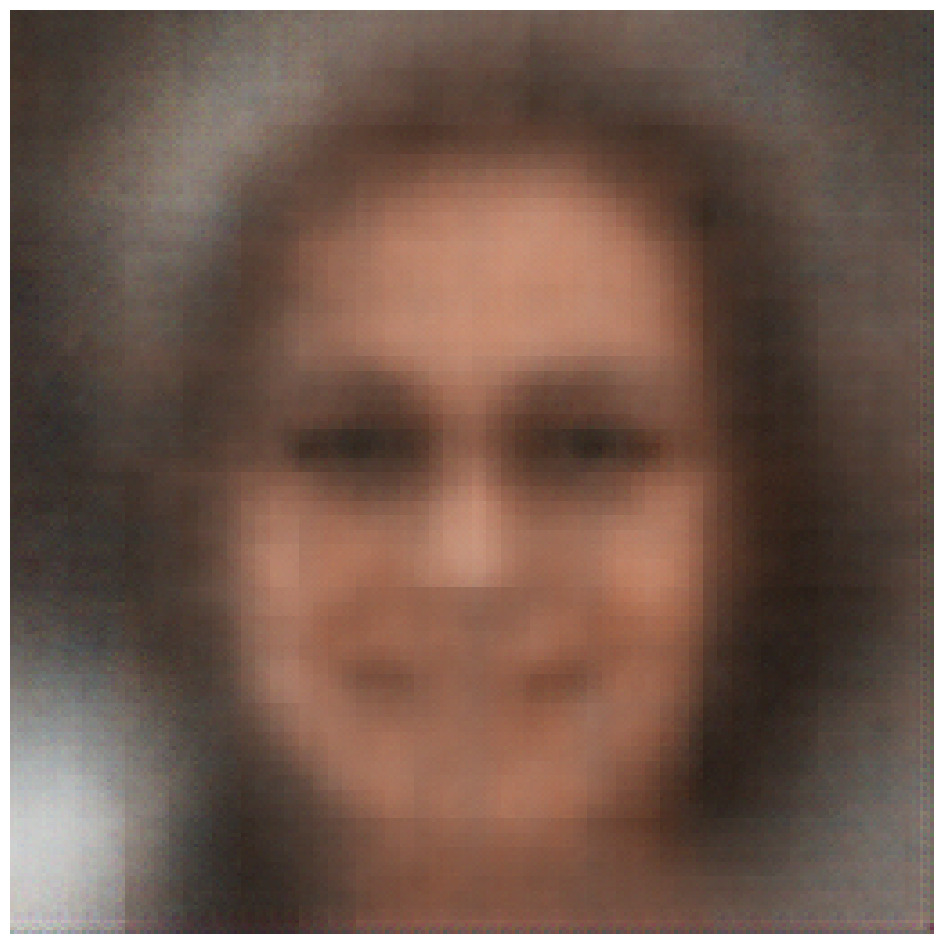

✅ Saved best model at epoch 6 with Eval Loss: 0.0293


[Eval ] Epoch 7/40: 100%|██████████| 163/163 [00:59<00:00,  2.76it/s]


Epoch  7: Train Loss = 0.0292, Eval Loss = 0.0290
✅ Saved best model at epoch 7 with Eval Loss: 0.0290


[Eval ] Epoch 8/40: 100%|██████████| 163/163 [00:58<00:00,  2.78it/s]


Epoch  8: Train Loss = 0.0289, Eval Loss = 0.0285
✅ Saved best model at epoch 8 with Eval Loss: 0.0285


[Eval ] Epoch 9/40: 100%|██████████| 163/163 [00:58<00:00,  2.76it/s]


Epoch  9: Train Loss = 0.0288, Eval Loss = 0.0284
✅ Saved best model at epoch 9 with Eval Loss: 0.0284


[Eval ] Epoch 10/40: 100%|██████████| 163/163 [00:58<00:00,  2.79it/s]


Epoch 10: Train Loss = 0.0286, Eval Loss = 0.0283
✅ Saved best model at epoch 10 with Eval Loss: 0.0283


[Eval ] Epoch 11/40: 100%|██████████| 163/163 [00:58<00:00,  2.78it/s]


Epoch 11: Train Loss = 0.0284, Eval Loss = 0.0282


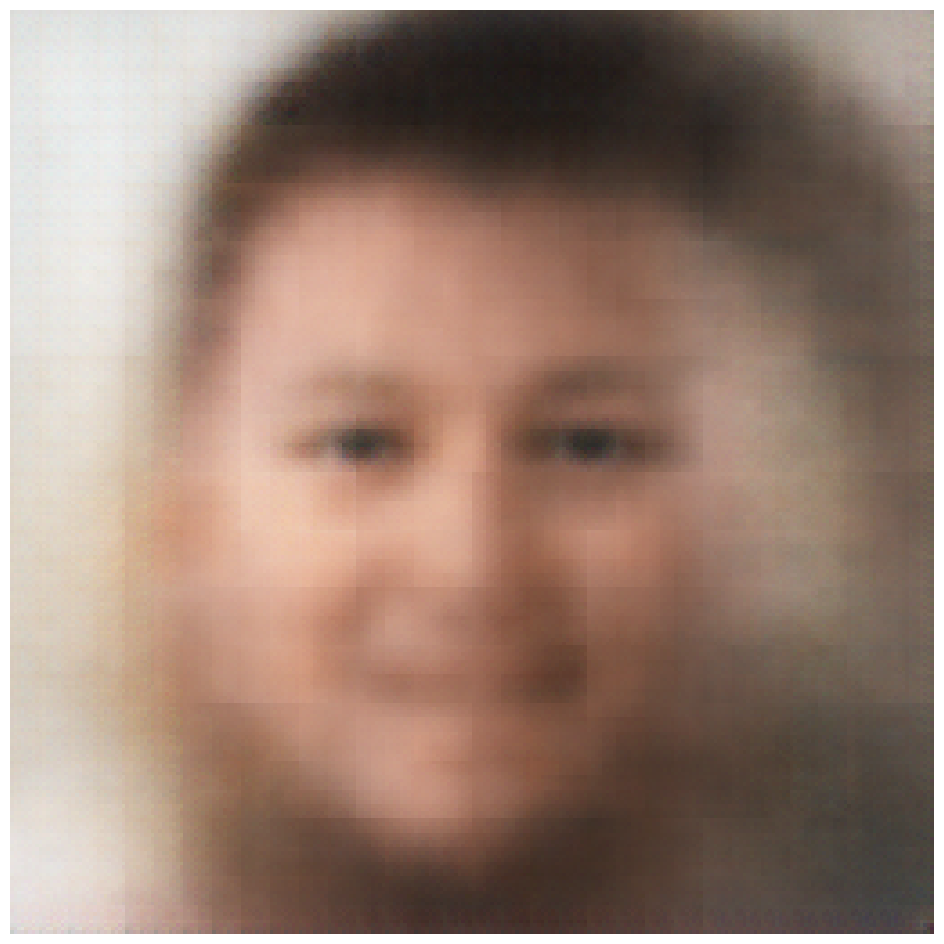

✅ Saved best model at epoch 11 with Eval Loss: 0.0282


[Eval ] Epoch 12/40: 100%|██████████| 163/163 [00:58<00:00,  2.78it/s]


Epoch 12: Train Loss = 0.0282, Eval Loss = 0.0282


[Eval ] Epoch 13/40: 100%|██████████| 163/163 [00:58<00:00,  2.76it/s]


Epoch 13: Train Loss = 0.0281, Eval Loss = 0.0279
✅ Saved best model at epoch 13 with Eval Loss: 0.0279


[Eval ] Epoch 14/40: 100%|██████████| 163/163 [00:58<00:00,  2.77it/s]


Epoch 14: Train Loss = 0.0280, Eval Loss = 0.0277
✅ Saved best model at epoch 14 with Eval Loss: 0.0277


[Eval ] Epoch 15/40: 100%|██████████| 163/163 [00:59<00:00,  2.76it/s]


Epoch 15: Train Loss = 0.0280, Eval Loss = 0.0277
✅ Saved best model at epoch 15 with Eval Loss: 0.0277


[Eval ] Epoch 16/40: 100%|██████████| 163/163 [00:58<00:00,  2.76it/s]


Epoch 16: Train Loss = 0.0279, Eval Loss = 0.0278


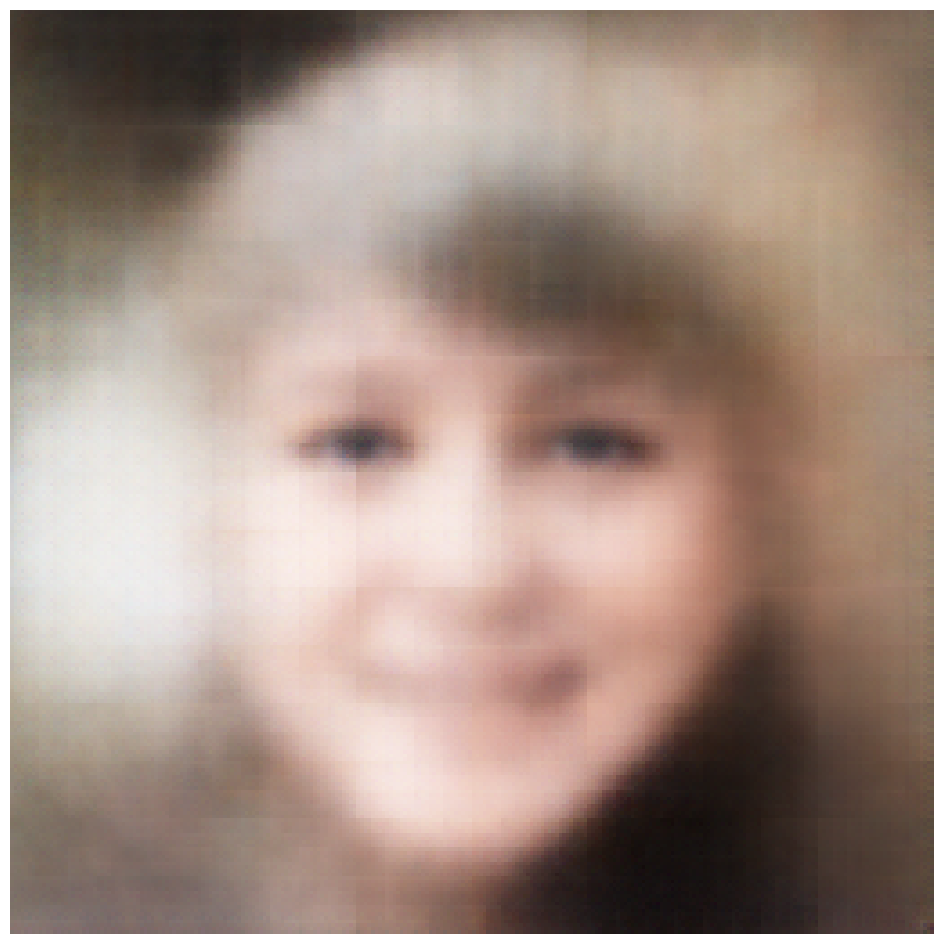

[Eval ] Epoch 17/40: 100%|██████████| 163/163 [00:56<00:00,  2.87it/s]


Epoch 17: Train Loss = 0.0278, Eval Loss = 0.0278


[Eval ] Epoch 18/40: 100%|██████████| 163/163 [00:57<00:00,  2.83it/s]


Epoch 18: Train Loss = 0.0277, Eval Loss = 0.0278


[Eval ] Epoch 19/40: 100%|██████████| 163/163 [00:57<00:00,  2.83it/s]


Epoch 19: Train Loss = 0.0277, Eval Loss = 0.0275
✅ Saved best model at epoch 19 with Eval Loss: 0.0275


[Eval ] Epoch 20/40: 100%|██████████| 163/163 [00:57<00:00,  2.83it/s]


Epoch 20: Train Loss = 0.0277, Eval Loss = 0.0275


[Eval ] Epoch 21/40: 100%|██████████| 163/163 [00:56<00:00,  2.87it/s]


Epoch 21: Train Loss = 0.0276, Eval Loss = 0.0274


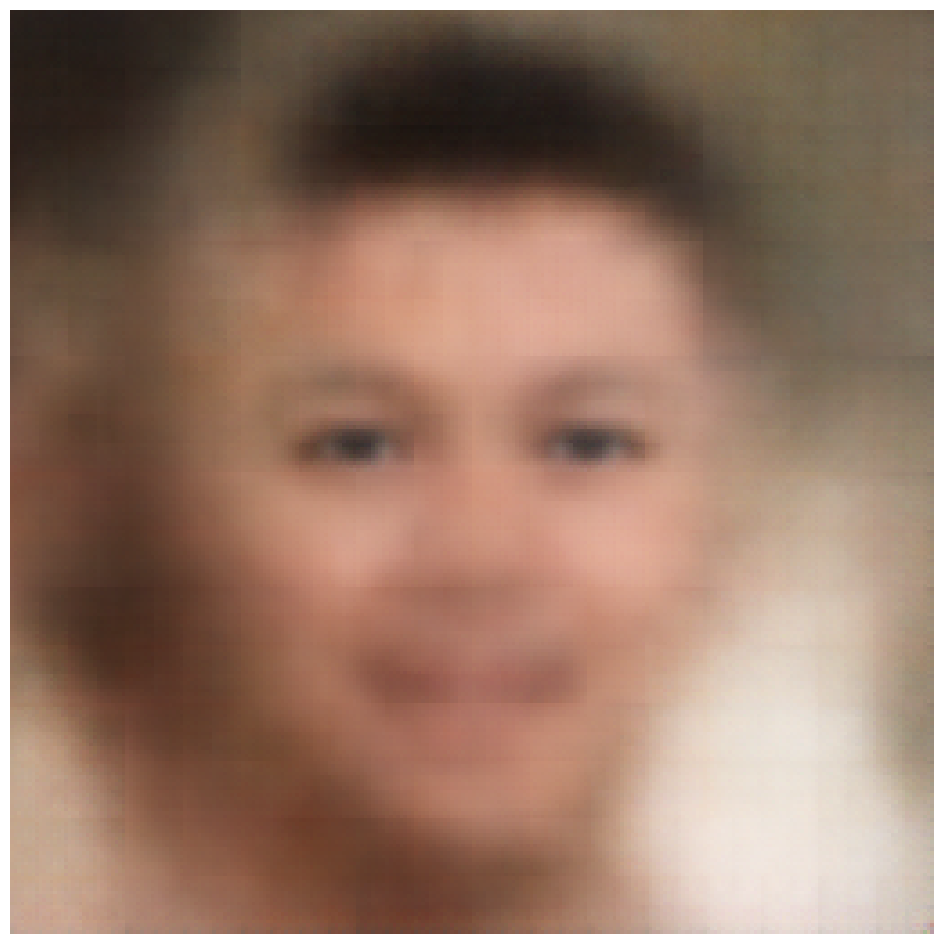

✅ Saved best model at epoch 21 with Eval Loss: 0.0274


[Eval ] Epoch 22/40: 100%|██████████| 163/163 [00:57<00:00,  2.85it/s]


Epoch 22: Train Loss = 0.0275, Eval Loss = 0.0274
✅ Saved best model at epoch 22 with Eval Loss: 0.0274


[Eval ] Epoch 23/40: 100%|██████████| 163/163 [00:57<00:00,  2.85it/s]


Epoch 23: Train Loss = 0.0275, Eval Loss = 0.0274
✅ Saved best model at epoch 23 with Eval Loss: 0.0274


[Eval ] Epoch 24/40: 100%|██████████| 163/163 [00:57<00:00,  2.84it/s]


Epoch 24: Train Loss = 0.0275, Eval Loss = 0.0274


[Eval ] Epoch 25/40: 100%|██████████| 163/163 [00:56<00:00,  2.87it/s]


Epoch 25: Train Loss = 0.0274, Eval Loss = 0.0273
✅ Saved best model at epoch 25 with Eval Loss: 0.0273


[Eval ] Epoch 26/40: 100%|██████████| 163/163 [00:57<00:00,  2.83it/s]


Epoch 26: Train Loss = 0.0274, Eval Loss = 0.0272


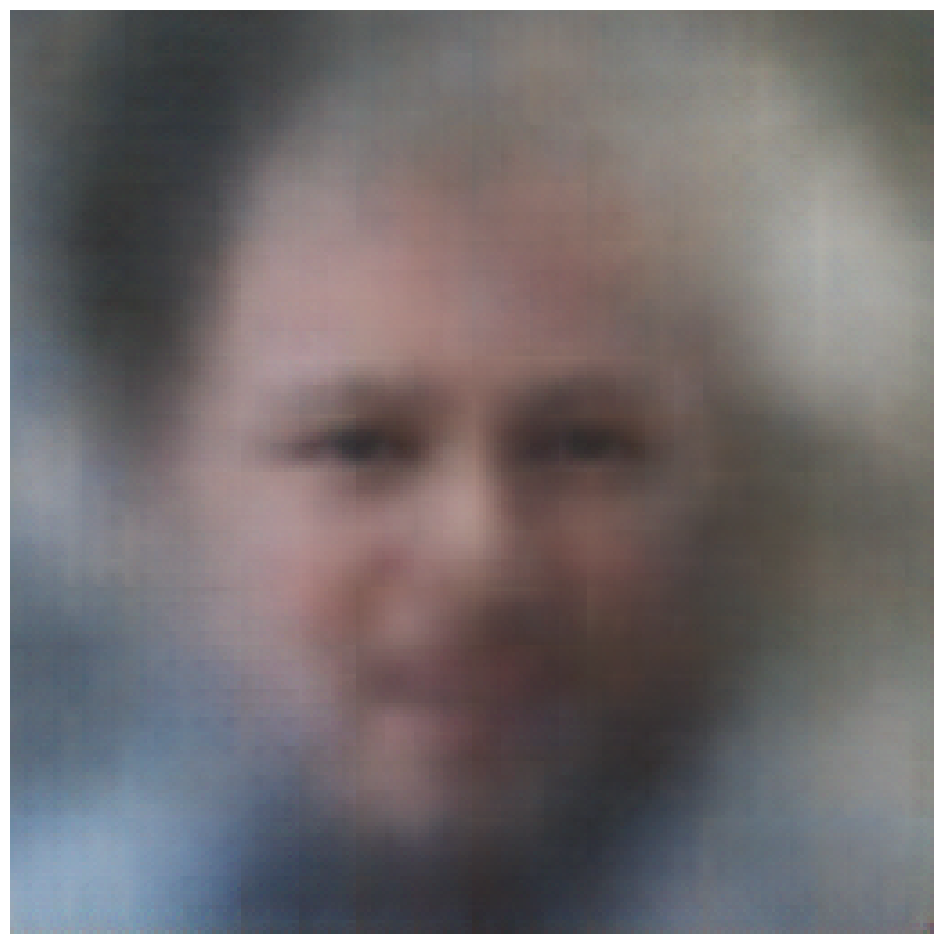

✅ Saved best model at epoch 26 with Eval Loss: 0.0272


[Eval ] Epoch 27/40: 100%|██████████| 163/163 [00:58<00:00,  2.78it/s]


Epoch 27: Train Loss = 0.0274, Eval Loss = 0.0273


[Eval ] Epoch 28/40: 100%|██████████| 163/163 [00:58<00:00,  2.78it/s]


Epoch 28: Train Loss = 0.0273, Eval Loss = 0.0273


[Eval ] Epoch 29/40: 100%|██████████| 163/163 [00:59<00:00,  2.74it/s]


Epoch 29: Train Loss = 0.0273, Eval Loss = 0.0272
✅ Saved best model at epoch 29 with Eval Loss: 0.0272


[Eval ] Epoch 30/40: 100%|██████████| 163/163 [00:58<00:00,  2.80it/s]


Epoch 30: Train Loss = 0.0273, Eval Loss = 0.0273


[Eval ] Epoch 31/40: 100%|██████████| 163/163 [00:59<00:00,  2.73it/s]


Epoch 31: Train Loss = 0.0272, Eval Loss = 0.0271


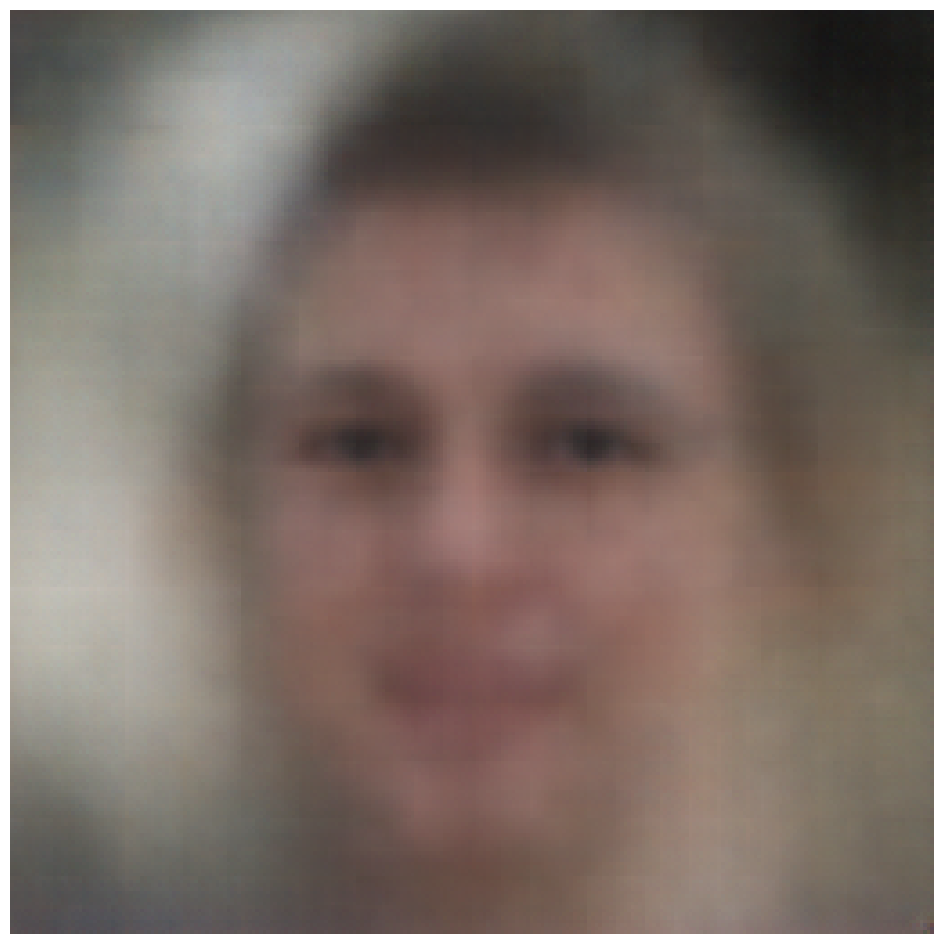

✅ Saved best model at epoch 31 with Eval Loss: 0.0271


[Eval ] Epoch 32/40: 100%|██████████| 163/163 [00:59<00:00,  2.76it/s]


Epoch 32: Train Loss = 0.0272, Eval Loss = 0.0272


[Eval ] Epoch 33/40: 100%|██████████| 163/163 [00:58<00:00,  2.78it/s]


Epoch 33: Train Loss = 0.0272, Eval Loss = 0.0271
✅ Saved best model at epoch 33 with Eval Loss: 0.0271


[Eval ] Epoch 34/40: 100%|██████████| 163/163 [00:58<00:00,  2.78it/s]


Epoch 34: Train Loss = 0.0272, Eval Loss = 0.0273


[Eval ] Epoch 35/40: 100%|██████████| 163/163 [00:58<00:00,  2.80it/s]


Epoch 35: Train Loss = 0.0271, Eval Loss = 0.0271


[Eval ] Epoch 36/40: 100%|██████████| 163/163 [00:57<00:00,  2.84it/s]


Epoch 36: Train Loss = 0.0271, Eval Loss = 0.0270


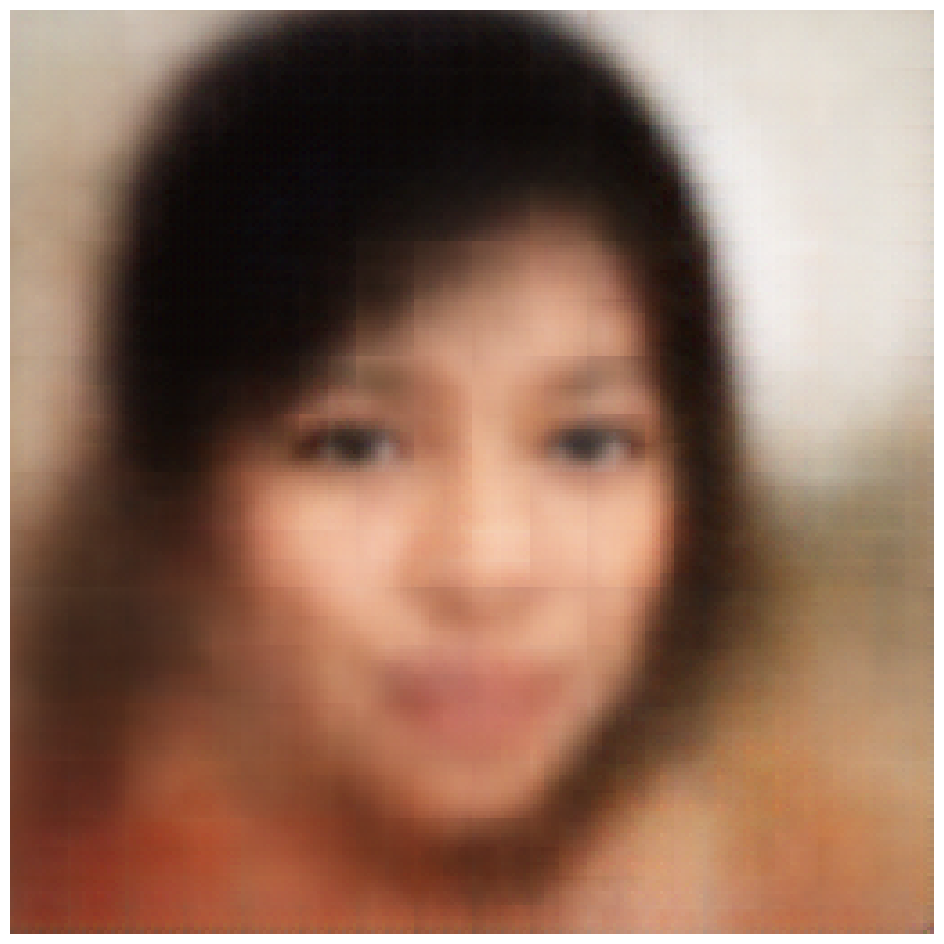

✅ Saved best model at epoch 36 with Eval Loss: 0.0270


[Eval ] Epoch 37/40: 100%|██████████| 163/163 [00:57<00:00,  2.82it/s]


Epoch 37: Train Loss = 0.0271, Eval Loss = 0.0271


[Eval ] Epoch 38/40: 100%|██████████| 163/163 [00:58<00:00,  2.80it/s]


Epoch 38: Train Loss = 0.0271, Eval Loss = 0.0271


[Eval ] Epoch 39/40: 100%|██████████| 163/163 [00:57<00:00,  2.82it/s]


Epoch 39: Train Loss = 0.0271, Eval Loss = 0.0272


[Eval ] Epoch 40/40: 100%|██████████| 163/163 [00:58<00:00,  2.80it/s]


Epoch 40: Train Loss = 0.0271, Eval Loss = 0.0270
✅ Saved best model at epoch 40 with Eval Loss: 0.0270


In [ ]:
# model = VAE()
# train_losses, eval_losses = train(model, train_loader, eval_loader, epochs=40, device=device)

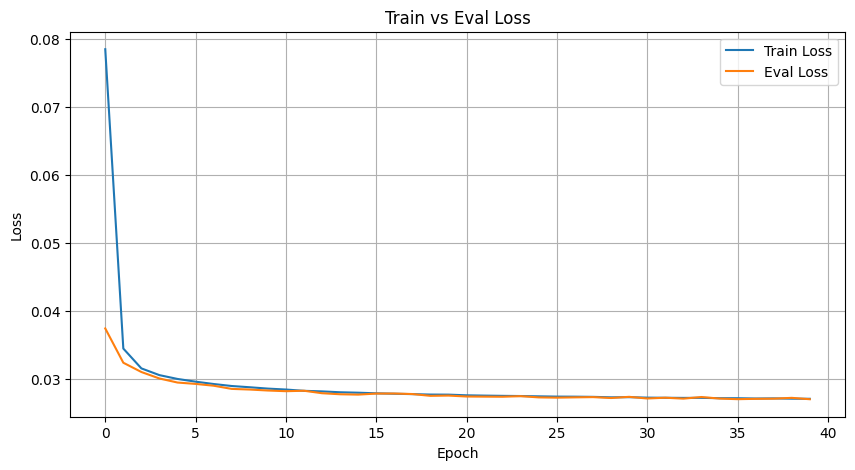

In [ ]:
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(eval_losses, label='Eval Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Eval Loss')
plt.legend()
plt.grid(True)
plt.show()

# Generation

In [5]:
# Show generated samples
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model_path = f"{checkpoint_dir}/vae_best.pth"
best_model = VAE().to(device)
best_model.load_state_dict(torch.load(best_model_path, map_location=device))
best_model.eval()
with torch.no_grad():
    samples = best_model.sample(1, current_device=device)
    # show_images(samples)

start = 168
save = True
os.makedirs("generated_vae", exist_ok=True)
generated_dir = "generated_vae"
if save:
    for i, sample in tqdm(enumerate(samples)):
        save_path = os.path.join(generated_dir, f"generated_vae_{start+i}.png")
        save_image(sample, save_path)

1it [00:16, 16.59s/it]


In [7]:
dir = "vae/generated_vae"
folder_path = "generated_vae"
filenames = [f"{dir}/{f}" for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
df = pd.DataFrame({'id': filenames})
df['label'] = 1
df.to_csv(f"iname_vae.csv", index=False)
df.shape

(5000, 2)